<a href="https://colab.research.google.com/github/alex-escobar-h/Facial-Expression-Recognition-Model/blob/main/facial_expression_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Facial Expression Recognition

## Install FER-2013 Dataset from Kaggle

In [1]:
from google.colab import userdata
import os
import torch
import torch.nn as nn
import torch.optim as optim

os.environ["KAGGLE_KEY"] = userdata.get('KAGGLE_KEY')
os.environ["KAGGLE_USERNAME"] = userdata.get('KAGGLE_USERNAME')
!pip install -q kaggle
!kaggle datasets download -d msambare/fer2013
!unzip -q fer2013.zip

Dataset URL: https://www.kaggle.com/datasets/msambare/fer2013
License(s): DbCL-1.0
fer2013.zip: Skipping, found more recently modified local copy (use --force to force download)
replace test/angry/PrivateTest_10131363.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


# Classes

## DataLoader Class

In [2]:
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data.sampler import SubsetRandomSampler
import torch.utils.data
import numpy as np


class DataLoader:
    def __init__(
        self,
        data_dir=".",
        batch_size=32,
        valid_size=0.2,
        image_size=48,
        num_workers=0,
    ):
        self.batch_size = batch_size
        self.valid_size = valid_size
        self.image_size = image_size
        self.data_dir = data_dir
        self.num_workers = num_workers

        self.classes = [
            "angry",
            "disgust",
            "fear",
            "happy",
            "neutral",
            "sad",
            "surprise",
        ]
        self.train_loader, self.valid_loader, self.test_loader = self._prepare_loaders()

    def _train_transform(self):
        return transforms.Compose(
            [
                # transforms.RandomHorizontalFlip(p=0.5),
                transforms.Resize((self.image_size, self.image_size)),
                transforms.Grayscale(num_output_channels=1),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.5], std=[0.5]),
            ]
        )

    def _test_transform(self):
        return transforms.Compose(
            [
                transforms.Resize((self.image_size, self.image_size)),
                transforms.Grayscale(num_output_channels=1),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.5], std=[0.5]),
            ]
        )

    def _prepare_loaders(self):
        # Load datasets
        train_data = datasets.ImageFolder(
            root=f"{self.data_dir}/train", transform=self._train_transform()
        )
        test_data = datasets.ImageFolder(
            root=f"{self.data_dir}/test", transform=self._test_transform()
        )

        # Split train into train/val
        num_train = len(train_data)
        indices = list(range(num_train))
        np.random.shuffle(indices)
        split = int(np.floor(self.valid_size * num_train))
        if self.valid_size > 0 and split == 0:
            split = 1  # Ensure at least one sample in validation set
        train_idx, valid_idx = indices[split:], indices[:split]

        train_sampler = SubsetRandomSampler(train_idx)
        valid_sampler = SubsetRandomSampler(valid_idx)

        train_loader = torch.utils.data.DataLoader(
            train_data,
            batch_size=self.batch_size,
            sampler=train_sampler,
            num_workers=self.num_workers,
        )
        valid_loader = torch.utils.data.DataLoader(
            train_data,
            batch_size=self.batch_size,
            sampler=valid_sampler,
            num_workers=self.num_workers,
        )
        test_loader = torch.utils.data.DataLoader(
            test_data, batch_size=self.batch_size, num_workers=self.num_workers
        )

        return train_loader, valid_loader, test_loader

## CNN Model Class

In [3]:
import torch.nn as nn


class CNN(nn.Module):
    def __init__(self, num_classes=7):
        super(CNN, self).__init__()

        self.conv_block1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 48x48 → 24x24
        )

        self.conv_block2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3),  # 24x24 → 22x22
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3),  # 22x22 → 20x20
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 20x20 → 10x10
        )

        self.conv_block3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3),  # 10x10 → 8x8
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 8x8 → 4x4
        )

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(128 * 4 * 4, 128)
        self.dropout = nn.Dropout(0.5)
        self.output = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.conv_block3(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.dropout(x)
        x = self.output(x)
        return x


## ModelTrainer Class

In [4]:
class ModelTrainer:
    def __init__(
        self,
        model,
        train_loader,
        valid_loader,
        criterion,
        optimizer,
        device,
        save_path="model_trained.pt",
    ):
        self.model = model
        self.train_loader = train_loader
        self.valid_loader = valid_loader
        self.criterion = criterion
        self.optimizer = optimizer
        self.device = device
        self.save_path = save_path
        self.best_valid_loss = float("inf")

    def train(self, num_epochs=5):
        for epoch in range(1, num_epochs + 1):
            train_loss = self._train_epoch()
            valid_loss = self._validate_epoch()
            print(
                f"Epoch {epoch} \tTrain Loss: {train_loss:.6f} \tVal Loss: {valid_loss:.6f}"
            )

            if valid_loss < self.best_valid_loss:
                print(
                    f"Validation loss decreased ({self.best_valid_loss:.6f} --> {valid_loss:.6f}). Saving model..."
                )
                torch.save(self.model.state_dict(), self.save_path)
                self.best_valid_loss = valid_loss

    def _train_epoch(self):
        self.model.train()
        total_loss = 0.0

        for data, target in self.train_loader:
            data, target = data.to(self.device), target.to(self.device)
            self.optimizer.zero_grad()
            output = self.model(data)
            loss = self.criterion(output, target)
            loss.backward()
            self.optimizer.step()
            total_loss += loss.item() * data.size(0)

        return total_loss / len(self.train_loader.sampler)

    def _validate_epoch(self):
        self.model.eval()
        total_loss = 0.0

        with torch.no_grad():
            for data, target in self.valid_loader:
                data, target = data.to(self.device), target.to(self.device)
                output = self.model(data)
                loss = self.criterion(output, target)
                total_loss += loss.item() * data.size(0)

        return total_loss / len(self.valid_loader.sampler)


## ModelTester Class

In [5]:
class ModelTester:
    def __init__(self, model, test_loader, criterion, classes, device):
        """
        Args:
            model (nn.Module): trained model
            test_loader (DataLoader): data loader for test set
            criterion (loss function): loss function used
            classes (list): list of class labels
            device (torch.device): device to run evaluation on
        """
        self.model = model
        self.test_loader = test_loader
        self.criterion = criterion
        self.classes = classes
        self.device = device

    def evaluate(self):
        self.model.eval()
        test_loss = 0.0
        num_classes = len(self.classes)
        class_correct = [0.0 for _ in range(num_classes)]
        class_total = [0.0 for _ in range(num_classes)]

        with torch.no_grad():
            for data, target in self.test_loader:
                data, target = data.to(self.device), target.to(self.device)
                output = self.model(data)
                loss = self.criterion(output, target)
                test_loss += loss.item() * data.size(0)

                _, pred = torch.max(output, 1)
                correct_tensor = pred.eq(target.view_as(pred))
                correct = correct_tensor.cpu().numpy()

                for i in range(len(target)):
                    label = target[i].item()
                    class_correct[label] += correct[i].item()
                    class_total[label] += 1

        test_loss /= len(self.test_loader.dataset)
        print(f"\nTest Loss: {test_loss:.6f}\n")

        for i in range(num_classes):
            if class_total[i] > 0:
                acc = 100.0 * class_correct[i] / class_total[i]
                print(
                    f"Test Accuracy of {self.classes[i]:8s}: {acc:2.0f}% "
                    f"({int(class_correct[i])}/{int(class_total[i])})"
                )
            else:
                print(f"Test Accuracy of {self.classes[i]:8s}: N/A (no samples)")

        overall = 100.0 * np.sum(class_correct) / np.sum(class_total)
        print(f"\nTest Accuracy (Overall): {overall:.2f}%")


## ImageVisualizer Class

In [6]:
import matplotlib.pyplot as plt
import numpy as np


class ImageVisualizer:
    def __init__(self, class_labels):
        self.class_labels = class_labels

    def imshow(self, img):
        img = img / 2 + 0.5  # unnormalize
        npimg = img.cpu().numpy()
        if npimg.shape[0] == 1:
            npimg = npimg.squeeze()
            plt.imshow(npimg, cmap="gray")
        else:
            npimg = np.transpose(npimg, (1, 2, 0))
            plt.imshow(npimg)
        plt.axis("off")

    def show_batch(self, images, labels, n=32, rows=4, cols=8):
        fig = plt.figure(figsize=(cols * 3, rows * 3))
        for idx in np.arange(min(n, len(images))):
            ax = fig.add_subplot(rows, cols, idx + 1, xticks=[], yticks=[])
            self.imshow(images[idx])
            ax.set_title(self.class_labels[labels[idx]])
        plt.show()

    def show_predictions(self, images, labels, preds, n=20, rows=2, cols=10):
        fig = plt.figure(figsize=(cols * 3, rows * 3))
        for idx in np.arange(min(n, len(images))):
            ax = fig.add_subplot(rows, cols, idx + 1, xticks=[], yticks=[])
            self.imshow(images[idx])
            pred_label = self.class_labels[preds[idx]]
            true_label = self.class_labels[labels[idx]]
            color = "green" if preds[idx] == labels[idx].item() else "red"
            ax.set_title(f"{pred_label} ({true_label})", color=color)
        plt.show()


# Main Code

Training on: cuda
Epoch 1 	Train Loss: 1.610059 	Val Loss: 1.336470
Validation loss decreased (inf --> 1.336470). Saving model...
Epoch 2 	Train Loss: 1.308718 	Val Loss: 1.255321
Validation loss decreased (1.336470 --> 1.255321). Saving model...
Epoch 3 	Train Loss: 1.209186 	Val Loss: 1.189510
Validation loss decreased (1.255321 --> 1.189510). Saving model...
Epoch 4 	Train Loss: 1.136313 	Val Loss: 1.166588
Validation loss decreased (1.189510 --> 1.166588). Saving model...
Epoch 5 	Train Loss: 1.068163 	Val Loss: 1.144508
Validation loss decreased (1.166588 --> 1.144508). Saving model...
Epoch 6 	Train Loss: 1.004497 	Val Loss: 1.098079
Validation loss decreased (1.144508 --> 1.098079). Saving model...
Epoch 7 	Train Loss: 0.937961 	Val Loss: 1.110562
Epoch 8 	Train Loss: 0.861281 	Val Loss: 1.099016
Epoch 9 	Train Loss: 0.793781 	Val Loss: 1.179018
Epoch 10 	Train Loss: 0.711385 	Val Loss: 1.212778
Epoch 11 	Train Loss: 0.632749 	Val Loss: 1.244172
Epoch 12 	Train Loss: 0.559415 	V

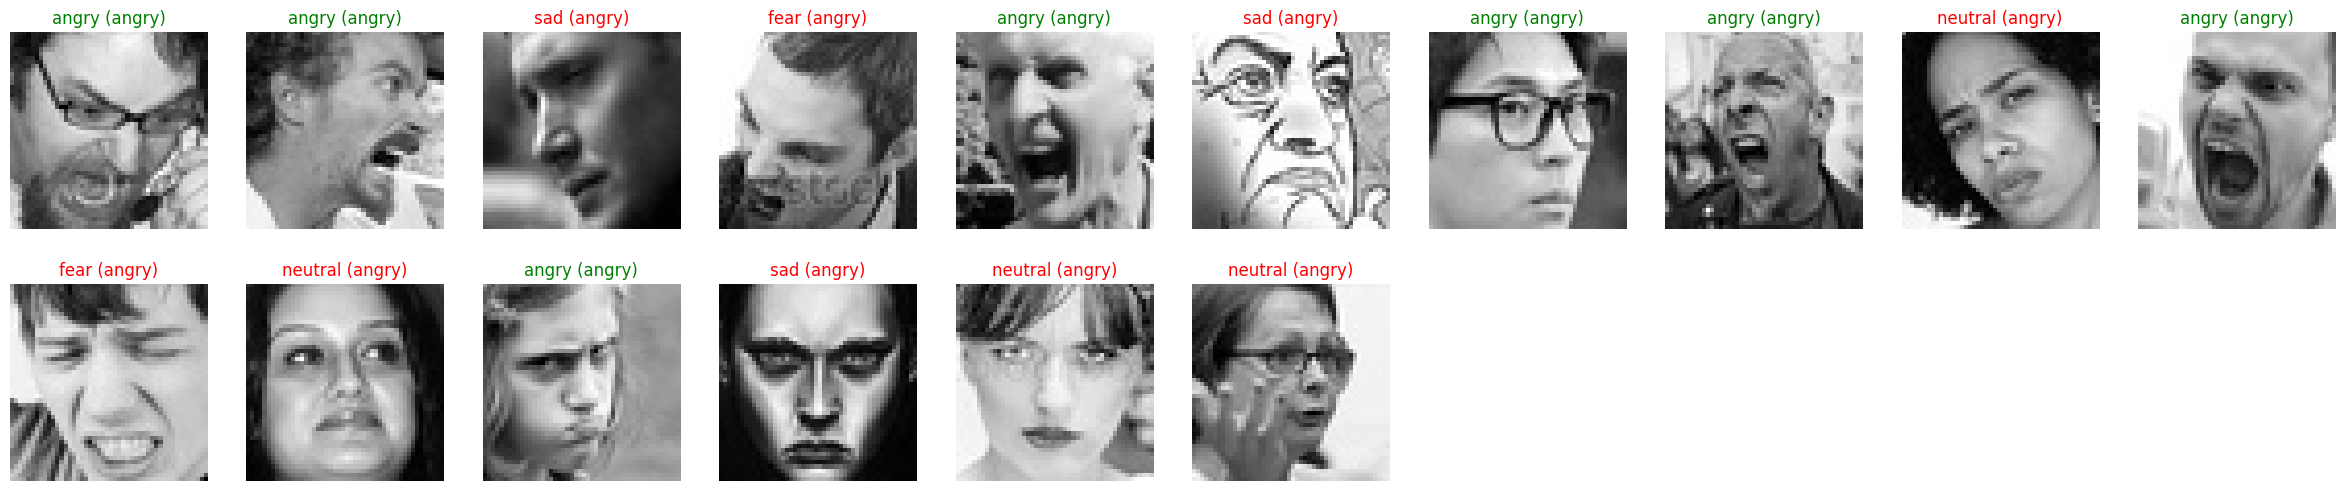

In [7]:
# 1. Set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Training on: {device}")

data_loader = DataLoader(batch_size=16)

# 2. Instantiate model and move it to device
model = CNN()      # Use CNN for a simple model
# model = Net()     # Use CNN2 for a more complex model
# model = VGGMini()   # Use VGGMini for a smaller model
model.to(device)

# 3. Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 4. Instantiate trainer and start training
trainer = ModelTrainer(
    model,
    data_loader.train_loader,
    data_loader.valid_loader,
    criterion,
    optimizer,
    device,
)
trainer.train(15)
tester = ModelTester(
    model, data_loader.test_loader, criterion, data_loader.classes, device
)
tester.evaluate()

# 5. Visualize predictions on a test batch
visualizer = ImageVisualizer(class_labels=data_loader.classes)

# Get one batch of test data
dataiter = iter(data_loader.test_loader)
images, labels = next(dataiter)

# Move images to the appropriate device
images_device = images.to(device)

# Set model to eval mode and get predictions
model.eval()
with torch.no_grad():
    outputs = model(images_device)
    _, preds_tensor = torch.max(outputs, 1)
    preds = preds_tensor.cpu().numpy()  # Always move to CPU for visualization

# Show predictions (move images to CPU if needed)
visualizer.show_predictions(images.cpu(), labels, preds, n=20, rows=2, cols=10)
